# Exemples cours sensibilisation explicabilité machine learning
ce notebook permet d'illustrer le cours avec des exemples. 
Dans ce cadre, les données et le modèle sont travaillés très rapidement.
<br />

Les data source proviennent de [Kaggle](https://www.kaggle.com/datasets/saurograndi/airplane-crashes-since-1908)






In [1]:
#Import des librairies
import pandas as pd
import numpy as np
import shap
from shapash.explainer.smart_explainer import SmartExplainer
from sklearn.model_selection import train_test_split
import catboost
import lightgbm
from sklearn.inspection import PartialDependenceDisplay

/home/maitrejinx/Documents/sensibilisation_explicabilite/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

## Import du dataset

In [3]:
df = pd.read_csv("../../data/era5_sample.csv")

In [4]:
df['valid_time'] = pd.to_datetime(df['valid_time'])
df['hour'] = df['valid_time'].dt.hour
df['wind_speed'] = np.sqrt(df['u10']**2 + df['v10']**2) * 3.6 #en km/h
df['t2m'] = df['t2m'] - 273.15 #en celsius

In [5]:
df.head(1)

,Unnamed: 0,time,step,latitude,longitude,number,surface,valid_time,d2m,t2m,ssrd,u10,v10,sp,tp,hour,wind_speed
0,8972251,2024-09-11,0 days 12:00:00,11.65,29.98,0,0.0,2024-09-11 12:00:00,296.1538,30.27505,18037366.0,0.476963,1.179552,93508.81,0.000489,12,4.580407


## Modélisation

In [6]:
features = ['latitude', 'longitude', 'd2m', 't2m', 'ssrd', 'sp', 'tp', 'hour', 'wind_speed']

In [7]:
df_reduit = df[features].copy()
df_reduit.dropna(inplace=True)

In [8]:
df_reduit["target"]=df_reduit["wind_speed"]
y = df_reduit["target"]
X = df_reduit.drop(["target", "wind_speed"], axis=1)

In [9]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, train_size=0.75, random_state=1
)

model = catboost.CatBoostRegressor()
model.fit(Xtrain, ytrain, verbose=False)

## Explicabilité

In [10]:
feature_dict = {
    'd2m': 'Température point de rosée',  
    't2m': 'Température',  
    'ssrd': 'Rayonnement solaire ',
    'sp': 'Pression',  
    'tp': 'Précipitations',  
}

In [11]:
#Init Shapash
xpl = SmartExplainer(model=model, features_dict=feature_dict)

In [12]:
# Compilation de Shapash
xpl.compile(
    x=Xtest,    
    y_target = ytest,
)

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7fa70d5b3fa0>


In [13]:
#Lancement de la webapp
app=xpl.run_app(port=8080)

INFO:root:Your Shapash application run on http://maitrejinx-Latitude-E5570:8080/
Address already in useINFO:root:Use the method .kill() to down your app.

Port 54112 is in use by another program. Either identify and stop that program, or start the server with a different port.


In [13]:
app.kill()

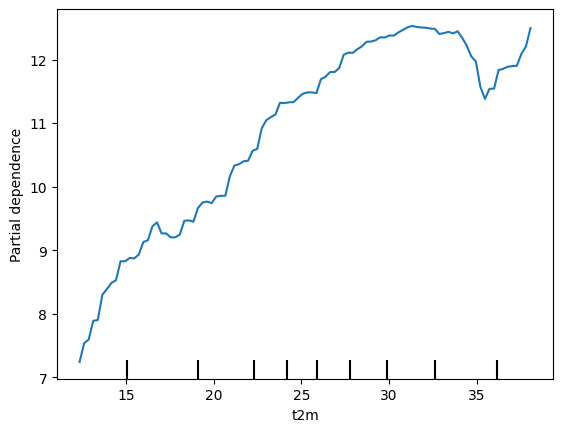

In [14]:
# PDP par sklearn
features_info = {
    # features of interest
    "features": ["t2m"]}

display = PartialDependenceDisplay.from_estimator(
    model,
    Xtest,
    **features_info,    
)

In [21]:
xpl.plot.contribution_plot(col="t2m")

In [16]:
xpl.plot.features_importance()

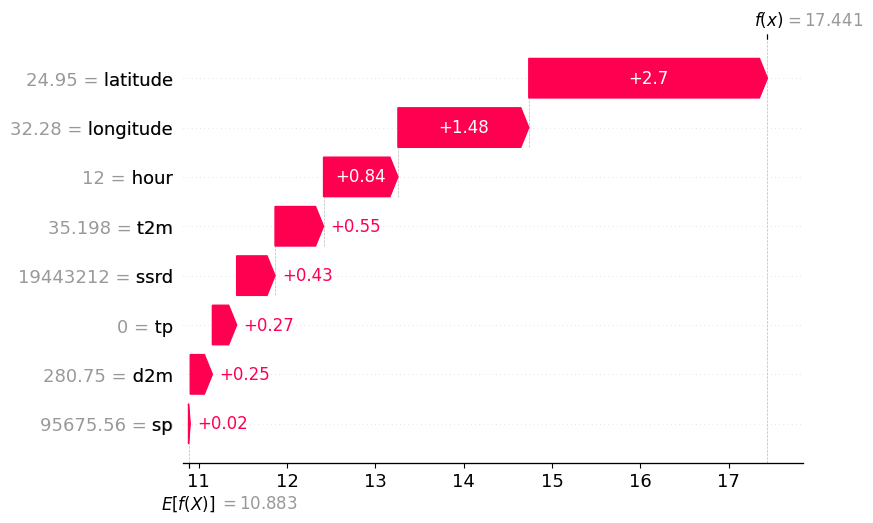

In [17]:
explainer = shap.Explainer(model)
shap_values = explainer(Xtest)
shap.plots.waterfall(shap_values[0])

In [19]:
xpl.plot.local_plot(index=Xtest.index[0])

In [27]:
model_lgb = lightgbm.LGBMRegressor()
model_lgb.fit(Xtrain, ytrain, verbose=False)

LGBMRegressor()

In [28]:
xpl_lgb = SmartExplainer(model=model_lgb,preprocessing=encoder)

xpl_lgb.compile(
    x=Xtest,    
    y_target = ytest
)

In [ ]:
xpl.plot.top_interactions_plot(nb_top_interactions=2)